In [1]:
import math
import random
import numpy as np
from scipy.stats import norm
from tqdm import tqdm as _tqdm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)

In [2]:
# Functions for Black-Scholes formulas
def option_value_bs(St, K, T, r, v, t=0):
    d1 = (math.log(St/K) + (r + v ** 2 * 0.5) * (T - t)) / (v * math.sqrt(T - t))
    d2 = d1 - v * math.sqrt(T - t)
    
    return St * norm.cdf(d1) - K * math.exp(-r * (T - t)) * norm.cdf(d2)

### Part I: Approximate the density

In [3]:
def approximate_normal_dist_Fourier():
    a = -10
    b = 10.0
    X = np.linspace(-5.0, 5.0, 200)
    coeff_order = np.arange(1, 7)

    true_pdf = norm.pdf(X)
    char_func = lambda u: np.exp(- u**2 / 2)
    F = lambda n, a, b: 2 / (b - a) * np.real(
        np.exp(-1j * (n * a * np.pi / (b - a))) * char_func(n * np.pi / (b - a)))
    
    distributions = {}
    errors = []
    
    for k in coeff_order:
        N = 2 ** k
        f_X = 1 / 2 * F(0, a, b)
        for n in range(1, N):
            f_X += F(n, a, b) * np.cos(n * np.pi * (X - a) / (b - a))

        distributions[N] = f_X
        errors.append(np.linalg.norm(true_pdf - f_X))
    
    return distributions, X, true_pdf, coeff_order, errors

In [4]:
def plot_normal_density(distributions, X, true_pdf, coeff_order, errors):
    plt.figure(figsize=(10, 8))
    for N, f in distributions.items():
        plt.plot(X, f, label=f'N={N}', alpha=0.8)
    plt.plot(X, true_pdf, label='True density', color='k', alpha=0.5)
    plt.legend()
    plt.xticks(np.arange(-5, 6), [str(i) for i in np.arange(-5, 6)])
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Standard Normal density approximation by Fourier cosine expansion')
    plt.show()
    
    
    plt.figure(figsize=(10, 8))
    plt.plot(coeff_order, errors)
    plt.xlabel('N')
    plt.xticks(coeff_order, [str(2**k) for k in coeff_order])
    plt.ylabel('Error')
    plt.title('Error of approximation')
    plt.show()
    

    plt.figure(figsize=(10, 8))
    plt.plot(coeff_order, np.log(errors))
    plt.xlabel('N')
    plt.xticks(coeff_order, [str(2**k) for k in coeff_order])
    plt.ylabel('Log(Error)')
    plt.title('Log error of approximation')
    plt.show()

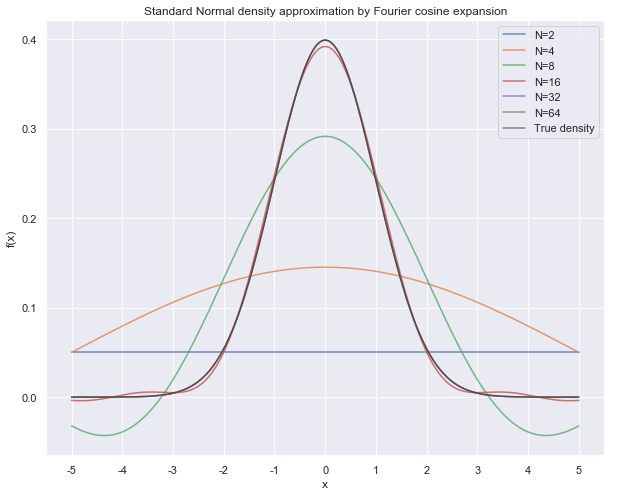

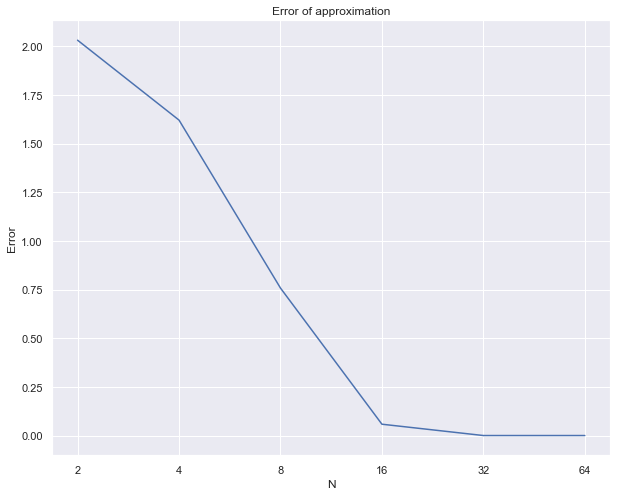

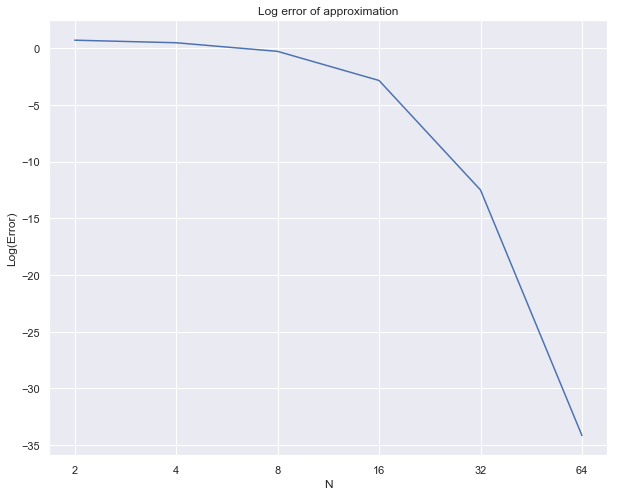

In [5]:
distributions, X, true_pdf, coeff_order, errors = approximate_normal_dist_Fourier()
plot_normal_density(distributions, X, true_pdf, coeff_order, errors)

In [6]:
def plot_separate(distributions, X, true_pdf, coeff_order, errors):
    plt.figure(figsize=(16, 30))
    
    for idx, k in enumerate(coeff_order):
        N = 2**k
        plt.subplot(6, 2, idx + 1)
        plt.plot(X, distributions[N], label=f'N={N}', alpha=0.8)
        plt.plot(X, true_pdf, label='True density', color='k', alpha=0.5)
        plt.legend()
        plt.xticks(np.arange(-5, 6), [str(i) for i in np.arange(-5, 6)])
        plt.xlabel('x')
        plt.ylabel('f(x)')
    
    plt.show()

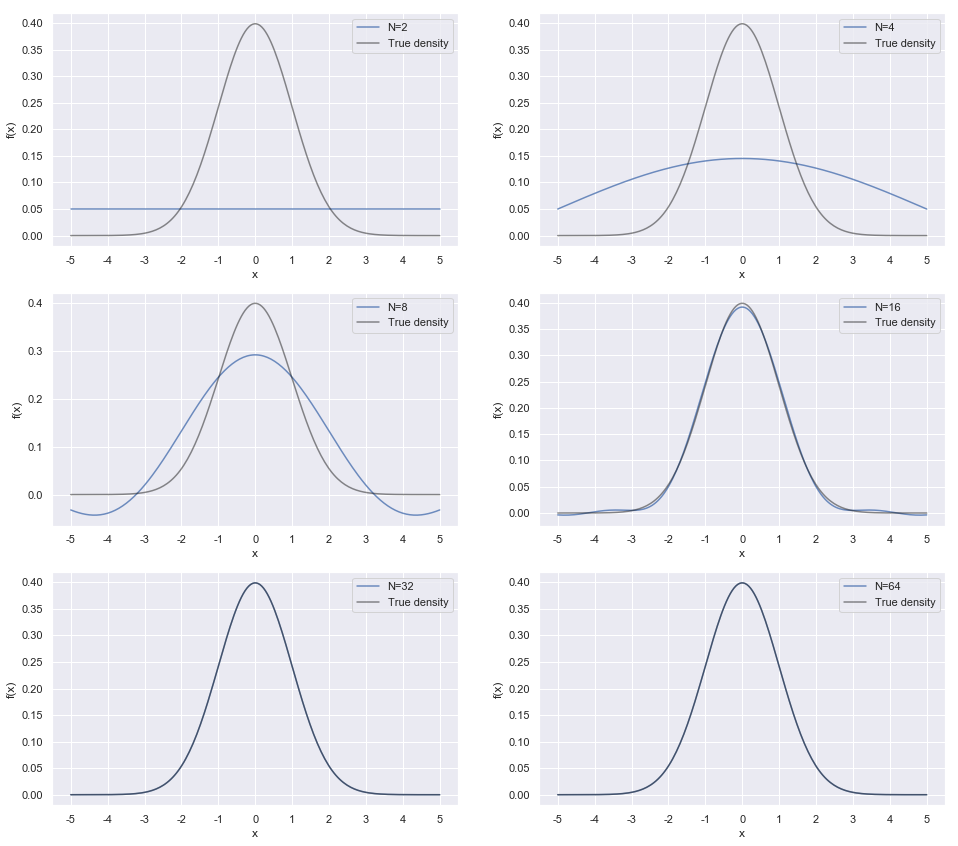

In [7]:
plot_separate(distributions, X, true_pdf, coeff_order, errors)

### Part II: Option pricing

In [8]:
def F_k(k, a, b, r, v, t, x):
    phi = lambda u, r, v, t: np.exp(1j * u * (r - v**2 / 2) * t - v ** 2 / 2 * t * u**2)
    
    u = k * np.pi / (b - a)
    
    if k == 0:
        x = 1 / (b - a) * np.real(phi(u, r, v, t) * np.exp(1j * k * np.pi * (x - a) / (b - a)))
    else:
        x = 2 / (b - a) * np.real(phi(u, r, v, t) * np.exp(1j * k * np.pi * (x - a) / (b - a)))
    
    return x

In [9]:
def G_k(k, a, b, K_price):
    diff = b - a
    
    Psi = (np.cos(k * np.pi) * np.exp(b) -
           np.cos(-k * np.pi * a / diff) +
           k * np.pi / diff * np.sin(k * np.pi) * np.exp(b) -
           k * np.pi / diff * np.sin(-k * np.pi * a / diff)) / (1 + (k * np.pi / diff)**2)
    
    if k == 0:
        Chi = b
    else:
        Chi = (np.sin(k * np.pi) - np.sin(-k * np.pi * a / diff)) * diff / (k * np.pi)
        
    return 2 / diff * K_price * (Psi - Chi)

In [10]:
def cos_method(S0=100, K=110, T=1, r=0.04, v=0.3, N=64):
    a = np.log(S0 / K) + r * T - 12 * np.sqrt(v**2 * T)
    b = np.log(S0 / K) + r * T + 12 * np.sqrt(v**2 * T)
    
    opt_price = 0
    x = np.log(S0 / K)
    
    for k in np.arange(0, N):
        opt_price += F_k(k, a, b, r, v, T, x) * G_k(k, a, b, K)
    
    opt_price *= np.exp(-r * T) * (b - a) / 2
    
    return opt_price

In [11]:
def plot_and_save_errors(coeff, err, ylabel='Absolute error', savefig=False, fname=''):
    plt.figure(figsize=(8, 6))
    plt.plot(coeff_order, err)
    plt.xlabel('Number of Fourier cosine coefficients')
    plt.ylabel(ylabel)
    if savefig:
        plt.savefig(fname, dpi=200)
    plt.show()

In [12]:
S0 = 100
K = 110
T = 1
r = 0.04
v = 0.3

coeff_order = np.arange(5, 65)
values_COS = []
errors = []
abs_errors = []

price_BS = option_value_bs(St=S0, K=K, T=T, r=r, v=v)

for N in coeff_order:
    price_COS = cos_method(S0=S0, K=K, T=T, r=r, v=v, N=N)
    error = price_COS - price_BS
    
    values_COS.append(price_COS)
    errors.append(error)
    abs_errors.append(abs(error))

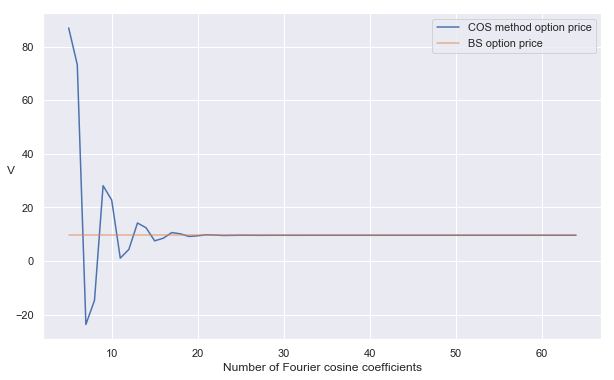

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(coeff_order, values_COS, label='COS method option price')
plt.plot(coeff_order, [price_BS for x in range(len(coeff_order))], alpha=0.6, label='BS option price')
plt.xlabel('Number of Fourier cosine coefficients')
plt.ylabel('V', rotation=0)
plt.legend()
plt.show()

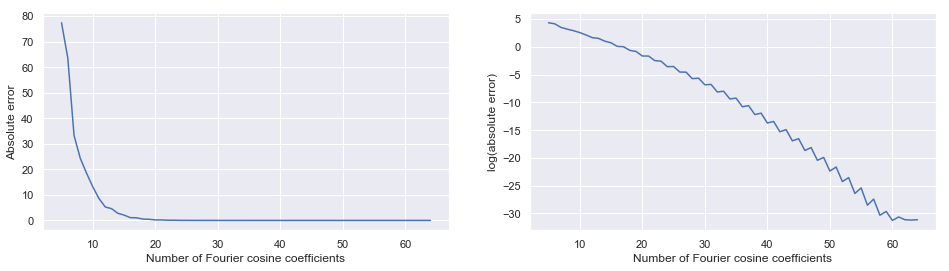

In [14]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(coeff_order, abs_errors)
plt.xlabel('Number of Fourier cosine coefficients')
plt.ylabel('Absolute error')

plt.subplot(1, 2, 2)
plt.plot(coeff_order, np.log(abs_errors))
plt.xlabel('Number of Fourier cosine coefficients')
plt.ylabel('log(absolute error)')

plt.show()

In [15]:
# plot_and_save_errors(coeff_order, abs_errors, ylabel='Absolute error',
#                      savefig=False, fname='COS_abs_error.png')

# plot_and_save_errors(coeff_order, np.log(abs_errors), ylabel='Log(absolute error)',
#                      savefig=False, fname='COS_log_abs_error.png')

In [16]:
coeff_order = np.arange(5, 65)
coeff_order = np.append(coeff_order, [96, 128, 160, 192])

price_BS = option_value_bs(St=S0, K=K, T=T, r=r, v=v)

values_COS = []
errors = []
abs_errors = []

for N in coeff_order:
    price_COS = cos_method(S0=S0, K=K, T=T, r=r, v=v, N=N)
    error = price_COS - price_BS
    
    values_COS.append(price_COS)
    errors.append(error)
    abs_errors.append(abs(error))

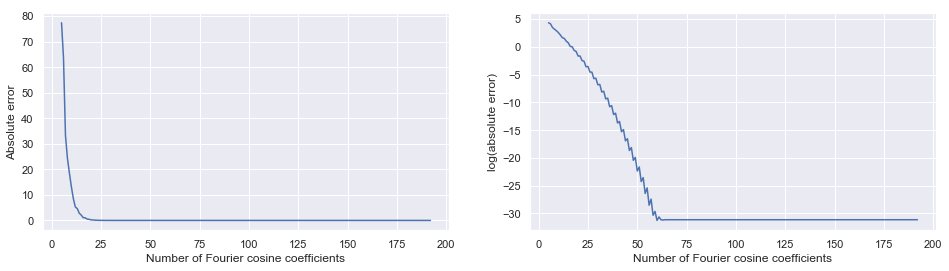

In [17]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(coeff_order, abs_errors)
plt.xlabel('Number of Fourier cosine coefficients')
plt.ylabel('Absolute error')

plt.subplot(1, 2, 2)
plt.plot(coeff_order, np.log(abs_errors))
plt.xlabel('Number of Fourier cosine coefficients')
plt.ylabel('log(absolute error)')

plt.show()

In [18]:
# plot_and_save_errors(coeff_order, abs_errors, ylabel='Absolute error',
#                      savefig=True, fname='COS_abs_error_all.png')

# plot_and_save_errors(coeff_order, np.log(abs_errors), ylabel='Log(absolute error)',
#                      savefig=True, fname='COS_log_abs_error_all.png')

In [19]:
coeff_order = np.array([64, 96, 128, 160, 192])

price_BS = option_value_bs(St=S0, K=K, T=T, r=r, v=v)

values_COS = []
errors = []
abs_errors = []

for N in coeff_order:
    price_COS = cos_method(S0=S0, K=K, T=T, r=r, v=v, N=N)
    error = price_COS - price_BS
    
    values_COS.append(price_COS)
    errors.append(error)
    abs_errors.append(abs(error))

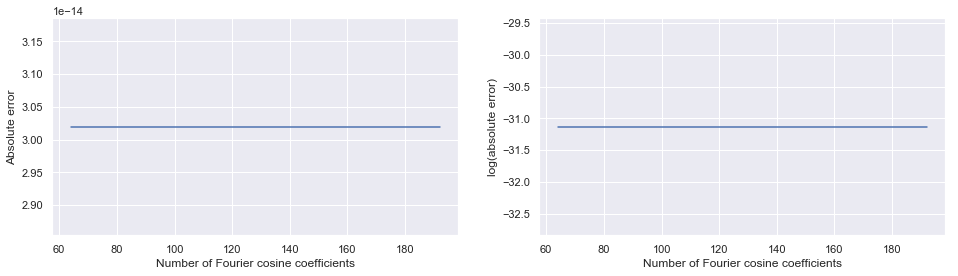

In [20]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(coeff_order, abs_errors)
plt.xlabel('Number of Fourier cosine coefficients')
plt.ylabel('Absolute error')

plt.subplot(1, 2, 2)
plt.plot(coeff_order, np.log(abs_errors))
plt.xlabel('Number of Fourier cosine coefficients')
plt.ylabel('log(absolute error)')

plt.show()

In [21]:
# plot_and_save_errors(coeff_order, abs_errors, ylabel='Absolute error',
#                      savefig=True, fname='COS_abs_error_small.png')

# plot_and_save_errors(coeff_order, np.log(abs_errors), ylabel='Log(absolute error)',
#                      savefig=True, fname='COS_log_abs_error_small.png')